Name : Shravani Ankur Wanjari
------------------------------
Student ID: 22WU0101093
-----------------------
Class: CSE - B
--------------

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm


In [4]:
data = yf.download("GOOGL", start='2015-01-01', end='2025-01-01')

data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2015-01-02,26.351517,26.662530,26.268412,26.503289,26480000
2015-01-05,25.849415,26.273886,25.764323,26.232086,41182000
2015-01-06,25.211466,25.936498,25.157225,25.901167,54456000
2015-01-07,25.137321,25.452813,25.062679,25.425943,46918000
2015-01-08,25.224901,25.254260,24.633228,24.956185,73054000
...,...,...,...,...,...
2024-12-24,195.884399,195.884399,193.557078,194.615856,10403300
2024-12-26,195.375000,196.523671,194.156402,194.925505,12046600


In [8]:

def load_data():
    print("Downloading Microsoft data...")
    data = yf.download('GOOGL')
    data = data.copy()
    data.loc[:, "LogReturn"] = np.log(data["Close"] / data["Close"].shift(1))
    return data.dropna()



In [9]:
def compute_wasserstein_matrix(windows):
    n = len(windows)
    dist_matrix = np.zeros((n, n))
    
    print("Computing Wasserstein distances...")
    for i in tqdm(range(n)):
        for j in range(i, n):
            if len(windows[i]) == 0 or len(windows[j]) == 0:
                dist_matrix[i,j] = np.inf
            else:
                try:
                    dist = wasserstein_distance(windows[i], windows[j])
                    dist_matrix[i,j] = dist if not np.isnan(dist) else np.inf
                except:
                    dist_matrix[i,j] = np.inf
            dist_matrix[j,i] = dist_matrix[i,j]
    
    max_finite = np.max(dist_matrix[np.isfinite(dist_matrix)], initial=1.0)
    dist_matrix[~np.isfinite(dist_matrix)] = 10 * max_finite
    return dist_matrix / np.max(dist_matrix)  

In [10]:
def compute_regimes(data, window_size, n_clusters=3):
    print(f"\nAnalyzing {window_size}-day windows...")
    returns = data["LogReturn"].values
    windows = [returns[i:i+window_size] for i in range(len(returns)-window_size)]
    
    dist_matrix = compute_wasserstein_matrix(windows)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(dist_matrix)
    regimes = kmeans.labels_
    
    cluster_stats = []
    for i in range(n_clusters):
        cluster_returns = [windows[j] for j in range(len(windows)) if regimes[j] == i]
        mean_return = np.mean([np.mean(r) for r in cluster_returns])
        mean_vol = np.mean([np.std(r) for r in cluster_returns])
        cluster_stats.append((mean_return, mean_vol))
    
    sorted_clusters = np.argsort([stat[0] for stat in cluster_stats])[::-1]
    labels = ["Bull", "Sideways", "Bear"]
    regime_labels = [labels[sorted_clusters.tolist().index(x)] for x in regimes]
    
    return regime_labels, windows

In [11]:
def plot_results(data, regime_labels, windows, window_size):
    dates = data.index.to_numpy()
    price = data["Close"].values
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1]})
    
    ax1.plot(dates, price, color='black', lw=1)
    colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'gray'}
    for i, label in enumerate(regime_labels):
        start = dates[i]
        end = dates[i + window_size]
        ax1.axvspan(start, end, color=colors[label], alpha=0.1)
    ax1.set_title(f"MSFT Price with {window_size}-Day Regimes (1986-2025)", fontsize=14)
    ax1.set_ylabel("Price", fontsize=12)
    
    for i, label in enumerate(regime_labels):
        start = i + window_size
        end = start + 1 if i < len(regime_labels)-1 else len(data)
        ax2.scatter(dates[start:end], data["LogReturn"].iloc[start:end], 
                   color=colors[label], s=8, alpha=0.7, label=label if i == 0 else "")
    ax2.set_title(f"Daily Log Returns by {window_size}-Day Regime", fontsize=14)
    ax2.set_ylabel("Log Returns", fontsize=12)
    
    # Formatting
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # Add regime statistics
    stats_text = f"Regime Statistics ({window_size}-day windows):\n"
    for label in ['Bull', 'Sideways', 'Bear']:
        count = regime_labels.count(label)
        stats_text += f"{label}: {count} periods ({count/len(regime_labels):.1%})\n"
    plt.figtext(0.15, 0.02, stats_text, fontsize=11, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'MSFT_Regimes{window_size}days.png', dpi=300, bbox_inches='tight')
    plt.show()

[*********************100%***********************]  1 of 1 completed



Analyzing 30-day windows...
Computing Wasserstein distances...


100%|██████████| 5158/5158 [03:20<00:00, 25.77it/s] 


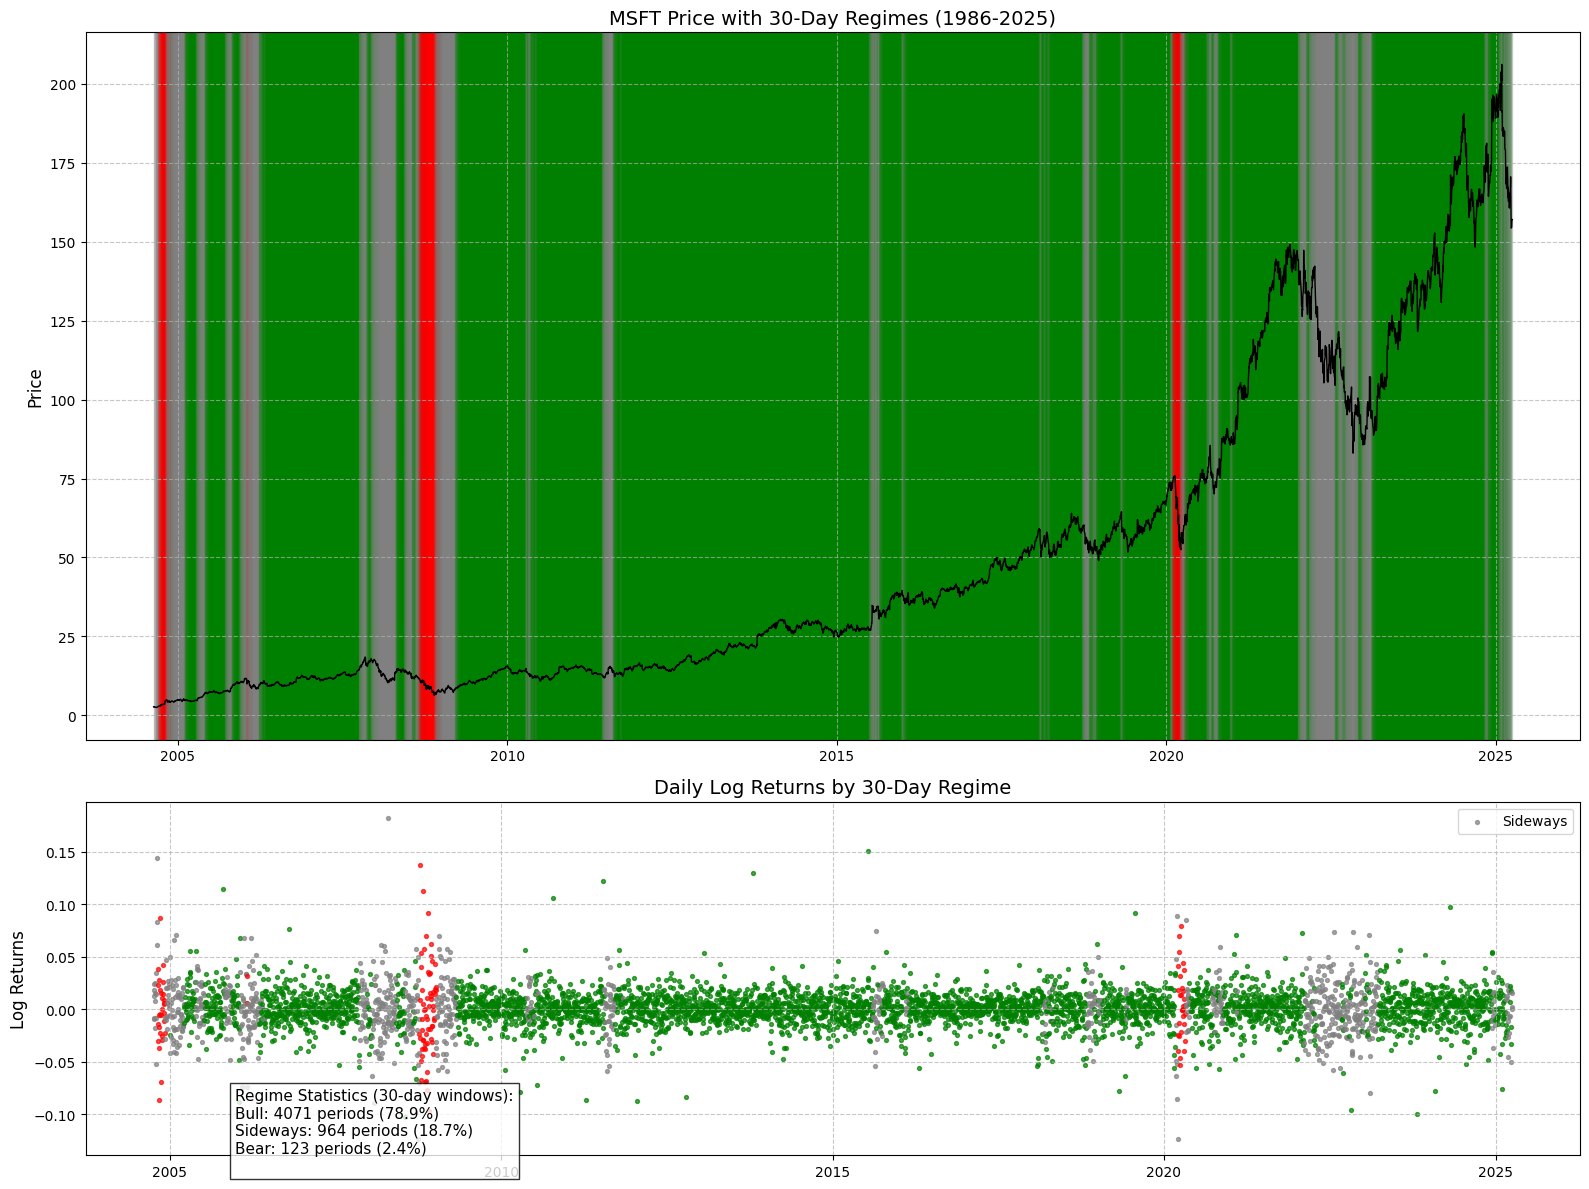


=== Regime Distribution ===

30 day windows:
Bull: 4071 periods (78.9%)
Sideways: 964 periods (18.7%)
Bear: 123 periods (2.4%)


In [12]:
def analyze_all_windows(data):

    
    # monthly (30 trading days) analysis
    labels_30, windows_30 = compute_regimes(data, window_size=30)
    plot_results(data, labels_30, windows_30, window_size=30)
    
    return {
        '30_day': {'labels': labels_30, 'windows': windows_30}
    }

if __name__ == "__main__":
    try:
        data = load_data()
        results = analyze_all_windows(data)
        
        # Print summary statistics
        print("\n=== Regime Distribution ===")
        for window_size in ['30_day']:
            print(f"\n{window_size.replace('_', ' ')} windows:")
            labels = results[window_size]['labels']
            for regime in ['Bull', 'Sideways', 'Bear']:
                count = labels.count(regime)
                print(f"{regime}: {count} periods ({count/len(labels):.1%})")
                
    except Exception as e:
        print(f"Error: {str(e)}")